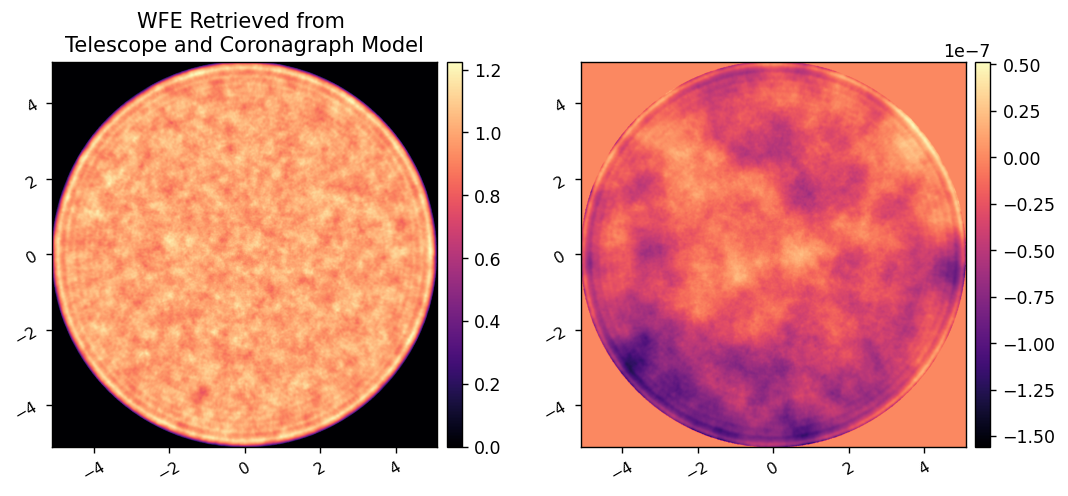

In [4]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
xp = cp if poppy.accel_math._USE_CUPY else np

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False

import warnings
warnings.filterwarnings("ignore")

from prop_models import compact, agpm
reload(compact)

from imshows import *

pupil_diam = 10.2*u.mm
wavelength_c = 650e-9*u.m

reload(agpm)
vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)
focal_ratio = 350/500 # focal lengths of relay OAPs from DM pupil to 
lyot_diam = 0.85 * pupil_diam
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2) # adjust by the ratio of focal lengths

# Load in the pupil plane wfe from the compact model of the coronagraph
wfe_fits = fits.open('phase-retrieval-data/post_fpm_pupil_wfe.fits')
coro_wfe = wfe_fits[0].data
wfe_pxscl = wfe_fits[0].header['PIXELSCL'] * u.m/u.pix
wfe_fits.close()
CORO_WFE = poppy.ArrayOpticalElement(transmission=coro_wfe[0], opd=coro_wfe[1], pixelscale=wfe_pxscl,)
imshow2(CORO_WFE.amplitude, CORO_WFE.opd, 
        'WFE Retrieved from \nTelescope and Coronagraph Model',
        pxscl=wfe_pxscl.to(u.mm/u.pix))

In [5]:
final_pupil_diam = focal_ratio*10.2*u.mm
final_focal_length = 200*u.mm

fnum = final_focal_length/ final_pupil_diam
spatial_resolution = wavelength_c * fnum
spatial_resolution.to(u.um)

<Quantity 18.20728291 um>

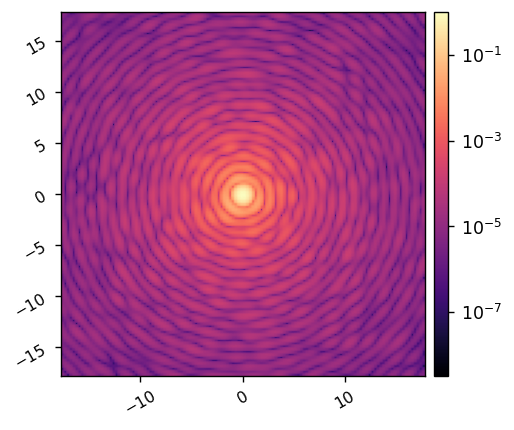

In [6]:
poppy_log.disabled = True

reload(compact)
c = compact.CORO()

c.npix = 512
c.oversample = 16
c.npsf = 128

c.reset_dm()

c.RETRIEVED = None
c.RETRIEVED = CORO_WFE

c.im_norm = c.snap().max()
ref_im = c.snap()

imshow1(ref_im, lognorm=True, pxscl=c.psf_pixelscale_lamD)

In [11]:
c.wavelength_c

<Quantity 6.5e-07 m>

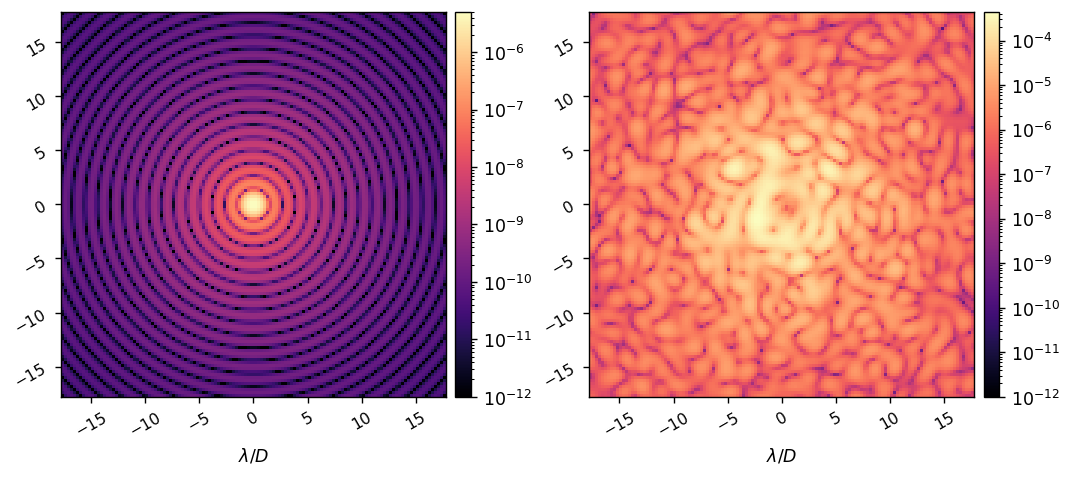

In [12]:
poppy_log.disabled = True

c.reset_dm()

c.FPM = vortex
c.LYOT = lyot_stop

c.RETRIEVED = None
occ_im_no_opds = c.snap()

c.RETRIEVED = CORO_WFE
occ_im_with_opds = c.snap()

imshow2(occ_im_no_opds, occ_im_with_opds,
        pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, 
        vmin1=1e-12, vmin2=1e-12)

In [47]:
c.Nact//2

17

In [45]:
xpp = np.arange(-c.Nact//2, c.Nact//2) + 1/2
xpp

array([-16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,  -9.5,  -8.5,
        -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,   0.5,
         1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
        10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5])

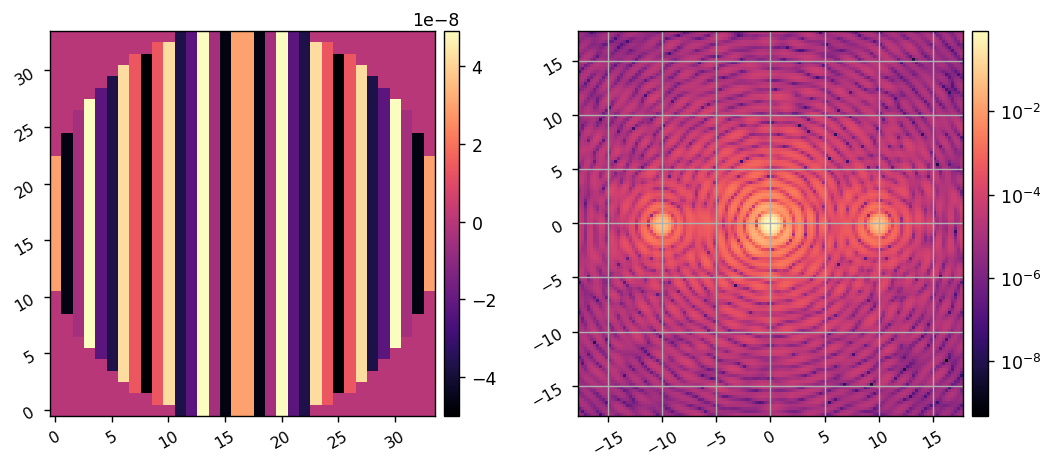

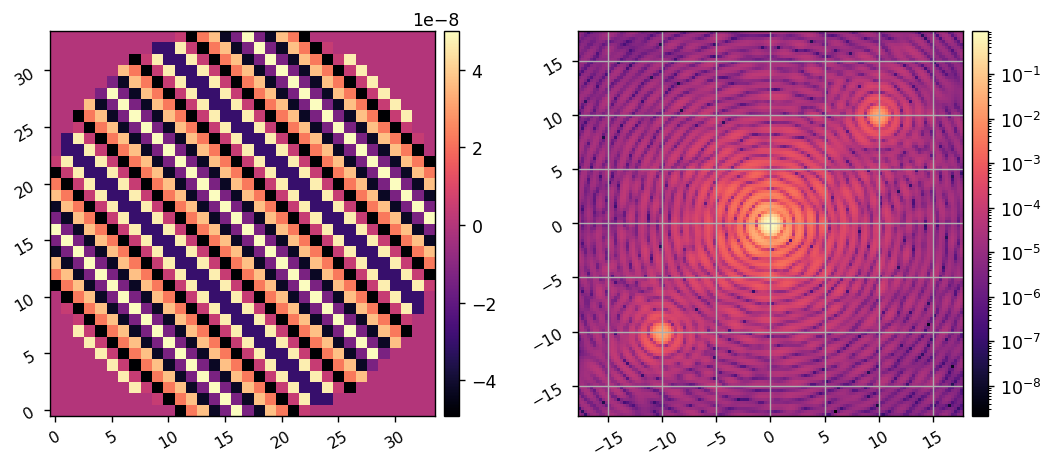

In [14]:
poppy_log.disabled = True

c.FPM = None
c.LYOT = None

Nact = c.Nact
xpp = np.arange(-c.Nact//2, c.Nact//2) + 1/2
ppx, ppy = np.meshgrid(xpp,xpp)

amp = 5e-8

separation = 10
com_1 = amp*np.cos(2*np.pi*ppx*separation/Nact)*c.dm_mask
com_2 = amp*np.cos(2*np.pi*(ppx + ppy)*separation/Nact)*c.dm_mask

c.set_dm(com_1)
im1 = c.snap()
imshow2(c.get_dm(), im1, pxscl2=c.psf_pixelscale_lamD, lognorm2=True, grid2=True)

c.set_dm(com_2)
im2 = c.snap()
imshow2(c.get_dm(), im2, pxscl2=c.psf_pixelscale_lamD, lognorm2=True, grid2=True)

In [38]:
np.sqrt()

7.0710678118654755

In [18]:
c.reset_dm()

wfs = c.calc_wfs()

Propagating wavelength 650.000 nm.
PSF calculated in 0.634s


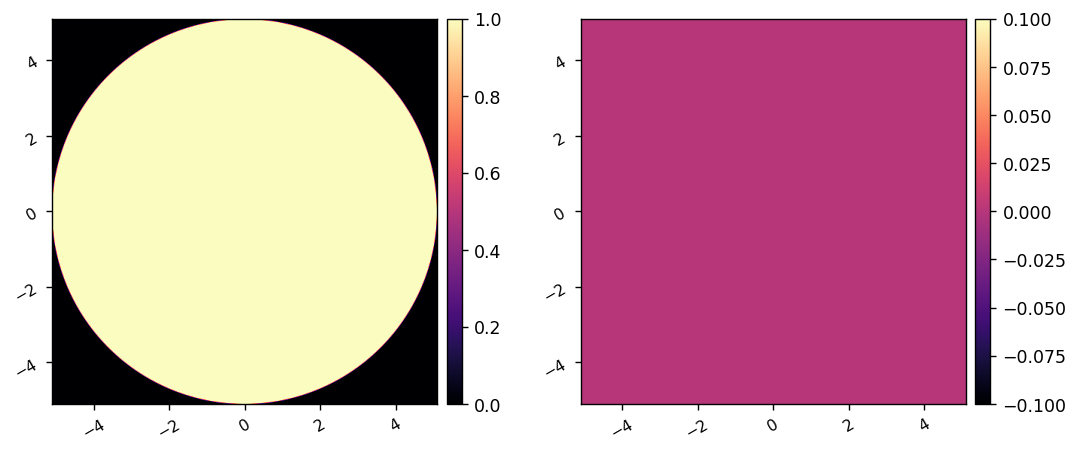

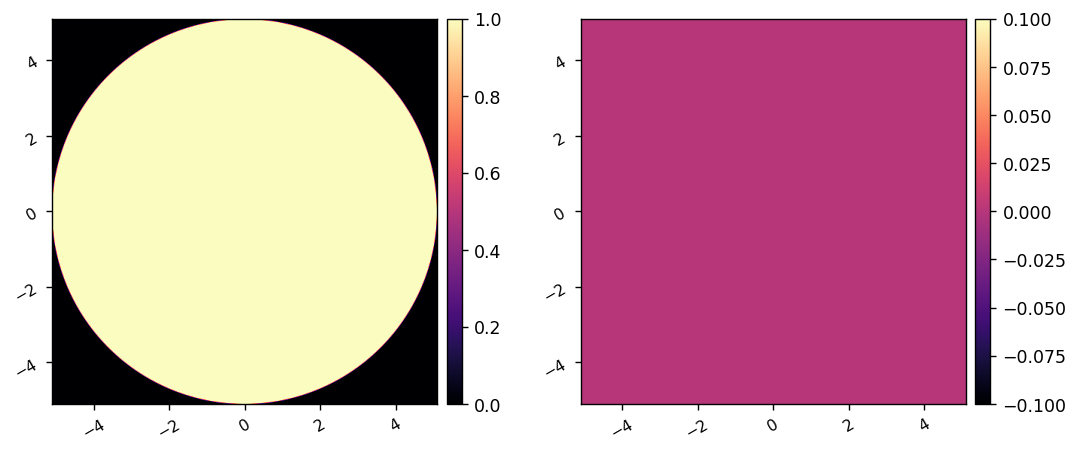

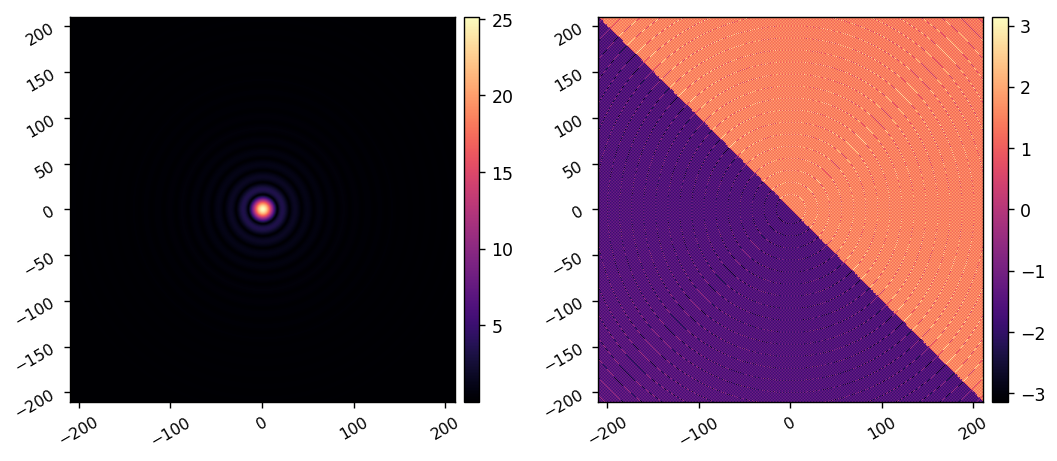

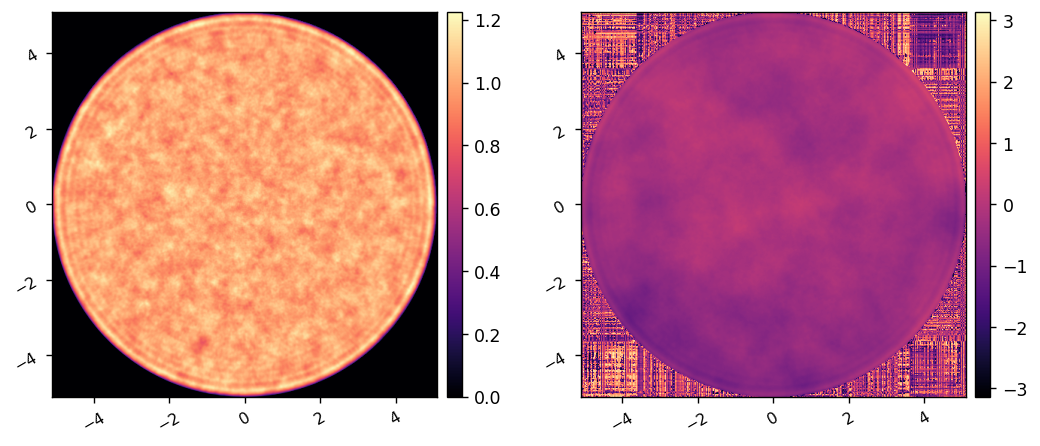

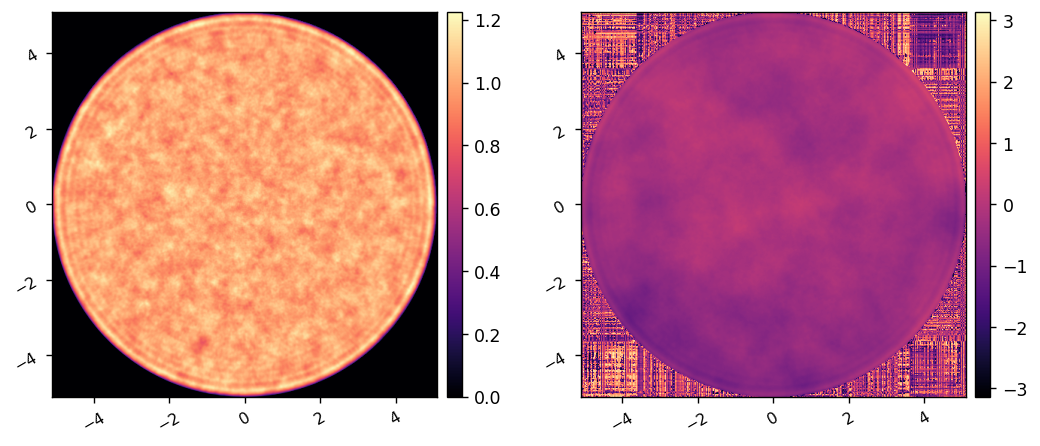

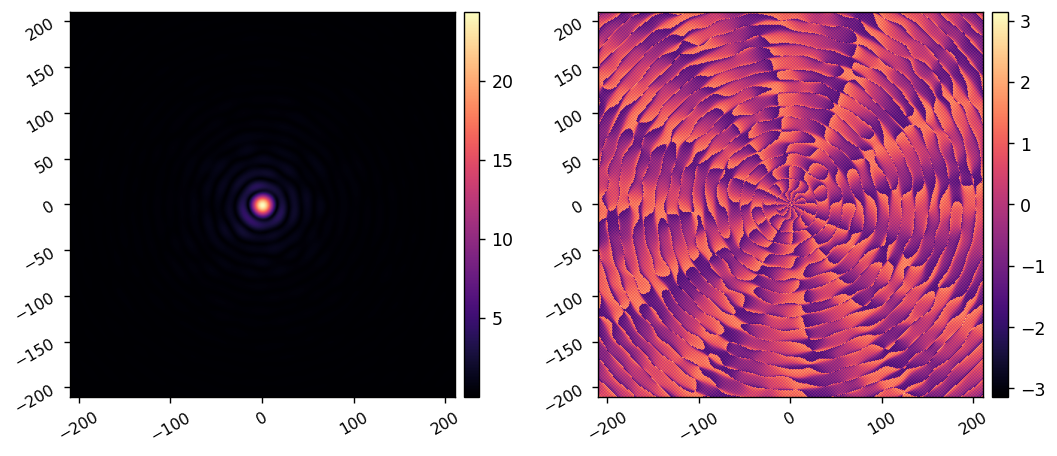

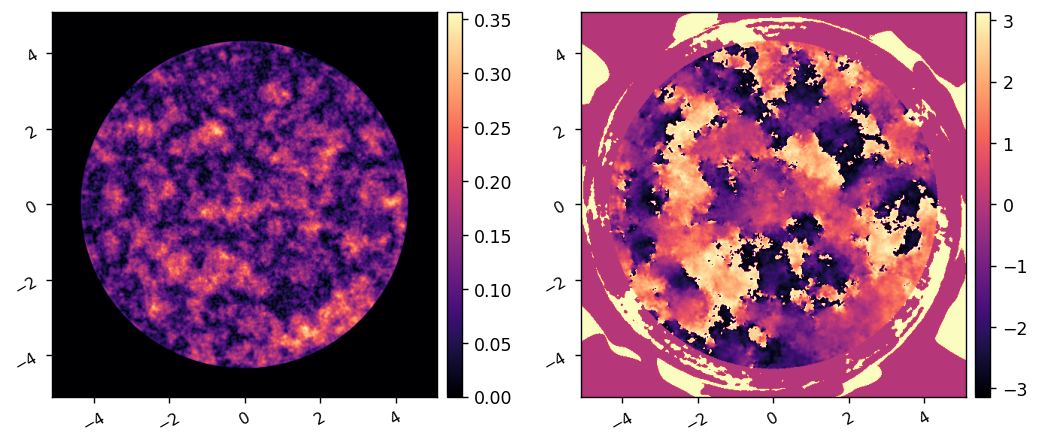

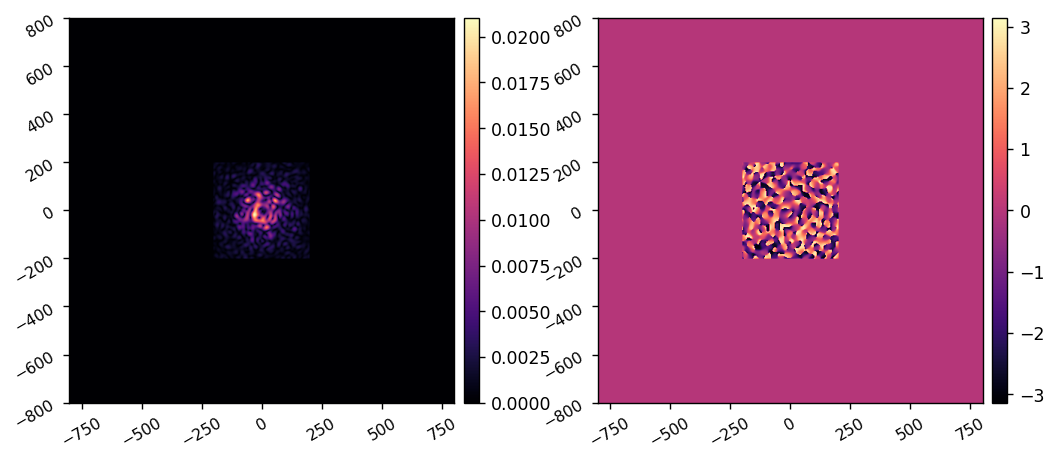

In [19]:
for i,wf in enumerate(wfs):
    imshow2(wf.amplitude, wf.phase, npix=c.npix, pxscl=wf.pixelscale)

In [21]:
10.2 * 0.85

8.67